# POLICY GRADIENT

## Environment I have tested for 

1) Acrobot - 'Acrobot-v1'
2) Lunar Lander - 'LunerLander-v3'
3) HalfCheetah - 'HalfCheetah-v5'
4) Ant - 'Ant-v5'
5) InvertedDoublePendulum


In [16]:
import gymnasium as gym
import torch 
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy as np


In [2]:
class HyperParams:
    gamma = 0.99
    lamda = 0.98
    hidden = 64
    critic_lr = 0.0003
    actor_lr = 0.0003
    batch_size = 64
    l2_rate = 0.001
    max_kl = 0.01
    clip_param = 0.2

hp = HyperParams()

class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, isDiscrete=False):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, num_outputs)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)
        self.isDiscrete = isDiscrete

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.fc3(x)
        if self.isDiscrete:
            return mu, None, None
        else:
            logstd = torch.zeros_like(mu)
            std = torch.exp(logstd)
            return mu, std, logstd


class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hp.hidden)
        self.fc2 = nn.Linear(hp.hidden, hp.hidden)
        self.fc3 = nn.Linear(hp.hidden, 1)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        v = self.fc3(x)
        return v


In [3]:

class PolicyGradient:
    def __init__(self, env_name):
        self.env = env_name
        self.num_states = None
        self.num_action = None
        self.isDiscrete = isinstance(gym.make(env_name).action_space, gym.spaces.Discrete)

    def log_density(self,x, mu, std, logstd):
        var = std.pow(2)
        log_density = - (x - mu).pow(2) / (2 * var) - 0.5 * np.log(2 * np.pi) - logstd
        return log_density.sum(1, keepdim=True)

    def get_returns(self,rewards, masks):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)

        running_returns = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + hp.gamma * running_returns * masks[t]
            returns[t] = running_returns

        returns = (returns - returns.mean()) / returns.std()
        return returns


    def get_loss(self, actor, returns, states, actions):
        states = torch.Tensor(states)
        actions = torch.Tensor(actions)
        returns = returns.unsqueeze(1)
        
        if self.isDiscrete:
            logits = actor(states)[0]
            dist = torch.distributions.Categorical(logits=logits)
            log_policy = dist.log_prob(actions.squeeze().long()).unsqueeze(1)
        else:
            mu, std, logstd = actor(states)
            log_policy = self.log_density(actions, mu, std, logstd)
        
        objective = (returns * log_policy).mean()
        return -objective



    def train_critic(self,critic, states, returns, critic_optim):
        criterion = torch.nn.MSELoss()
        n = len(states)
        arr = np.arange(n)

        for epoch in range(5):
            np.random.shuffle(arr)

            for i in range(n // hp.batch_size):
                batch_index = arr[hp.batch_size * i: hp.batch_size * (i + 1)]
                batch_index = torch.LongTensor(batch_index)
                inputs = torch.Tensor(states)[batch_index]
                target = returns.unsqueeze(1)[batch_index]

                values = critic(inputs)
                loss = criterion(values, target)
                critic_optim.zero_grad()
                loss.backward()
                critic_optim.step()


    def train_actor(self,actor, returns, states, actions, actor_optim):
        loss = self.get_loss(actor, returns, states, actions)
        actor_optim.zero_grad()
        loss.backward()
        actor_optim.step()


    def train_model(self,actor, critic, memory, actor_optim, critic_optim):
        states = np.vstack([m[0] for m in memory])
        actions = np.vstack([m[1] for m in memory])
        rewards = [m[2] for m in memory]
        masks = [m[3] for m in memory]

        returns = self.get_returns(rewards, masks)
        self.train_critic(critic, states, returns, critic_optim)
        self.train_actor(actor, returns, states, actions, actor_optim)
        return returns

    def make_env(self):
        env = gym.make(self.env)
        return env
    

    def get_action(self, actor, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        if self.isDiscrete:
            logits = actor(state_tensor)[0]
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample().item() 
        else:
            mu, std, _ = actor(state_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample().squeeze(0).detach().numpy()
            action = np.clip(action, -1, 1) 
        return action

    
    def main(self):
        env = self.make_env()

        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n if self.isDiscrete else env.action_space.shape[0]

        print("State space: ", self.num_states)
        print("Action space: ", self.num_actions)

        actor = Actor(self.num_states, self.num_actions, self.isDiscrete)
        critic = Critic(self.num_states)

        actor_optim = optim.Adam(actor.parameters(), lr=hp.actor_lr)
        critic_optim = optim.Adam(critic.parameters(), lr=hp.critic_lr, weight_decay=hp.l2_rate)

        writer = SummaryWriter(log_dir=f"runs/{self.env}_Policy Gradient")

        episodes = 0
        scores_over_time = []
        for iter in range(50):
            actor.eval(), critic.eval()
            memory = deque()

            steps = 0
            scores = []
            while steps < 10000:
                episodes += 1
                state = env.reset(seed=42)[0] 
                score = 0
                for _ in range(10000):

                    steps += 1 
                    
                    action = self.get_action(actor, state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    if done:
                        mask = 0
                    else:
                        mask = 1

                    memory.append([state, action, reward, mask])

                    score += reward
                    state = next_state

                    if done:
                        break
                scores.append(score)
            score_avg = np.mean(scores)
            scores_over_time.append(score_avg)
            print('{} episode score is {:.2f}'.format(episodes, score_avg))
            writer.add_scalar('log/score', float(score_avg), iter)

            actor.train(), critic.train()
            torch.save(actor.state_dict(), f'actor_{self.env}_PG.pth')
            torch.save(critic.state_dict(), f'critic_{self.env}_PG.pth')
            self.train_model(actor, critic, memory, actor_optim, critic_optim)

        np.save(f"scores_{self.env}_PG.npy", np.array(scores_over_time))

In [4]:
PG = PolicyGradient('Ant-v5')
PG.main()

State space:  105
Action space:  8
133 episode score is -93.57
215 episode score is -138.02
323 episode score is -108.47
384 episode score is -183.22
481 episode score is -119.01
565 episode score is -135.26
621 episode score is -211.42
708 episode score is -128.84
815 episode score is -109.58
902 episode score is -134.45
995 episode score is -123.01
1070 episode score is -157.86
1163 episode score is -122.13
1263 episode score is -114.91
1395 episode score is -85.44
1479 episode score is -129.92
1567 episode score is -136.83
1646 episode score is -151.25
1733 episode score is -127.96
1804 episode score is -165.37
1904 episode score is -119.41
2002 episode score is -117.56
2074 episode score is -162.02
2185 episode score is -110.80
2292 episode score is -108.37
2353 episode score is -182.19
2495 episode score is -82.10
2561 episode score is -185.34
2655 episode score is -131.02
2758 episode score is -115.01
2847 episode score is -138.24
2935 episode score is -126.96
3047 episode score 

8
Ant-v5


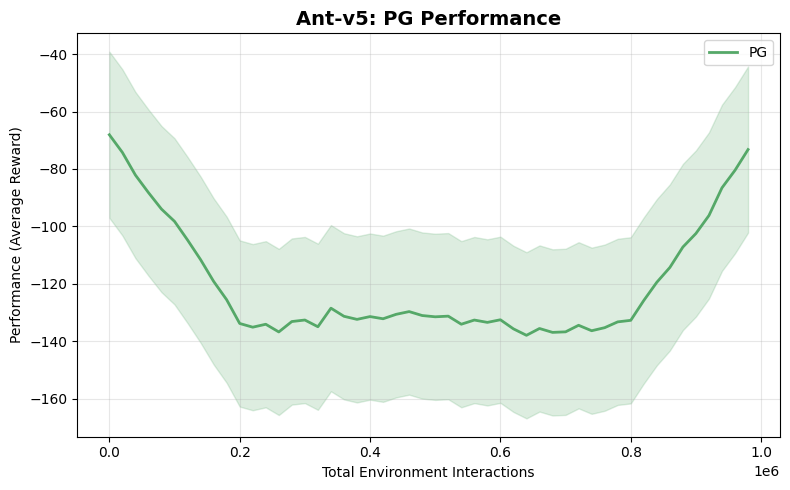

In [5]:
print(PG.num_actions)
print(PG.env)

actor = Actor(PG.num_states, PG.num_actions, PG.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{PG.env}_PG.pth"))

env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{PG.env}_PG.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PG")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{PG.env}: PG Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
PG = PolicyGradient('Acrobot-v1')  
PG.main()

State space:  6
Action space:  3
20 episode score is -500.00
40 episode score is -500.00
60 episode score is -500.00
81 episode score is -496.52
102 episode score is -495.62
122 episode score is -500.00
143 episode score is -494.38
163 episode score is -500.00
183 episode score is -500.00
204 episode score is -495.86
224 episode score is -500.00
245 episode score is -493.33
265 episode score is -500.00
285 episode score is -500.00
305 episode score is -500.00
326 episode score is -498.10
346 episode score is -500.00
366 episode score is -500.00
386 episode score is -500.00
407 episode score is -496.19
428 episode score is -497.52
448 episode score is -500.00
468 episode score is -500.00
488 episode score is -500.00
509 episode score is -493.71
530 episode score is -494.05
550 episode score is -500.00
571 episode score is -499.90
592 episode score is -488.48
612 episode score is -500.00
632 episode score is -500.00
653 episode score is -498.90
673 episode score is -500.00
694 episode sc

3
Acrobot-v1


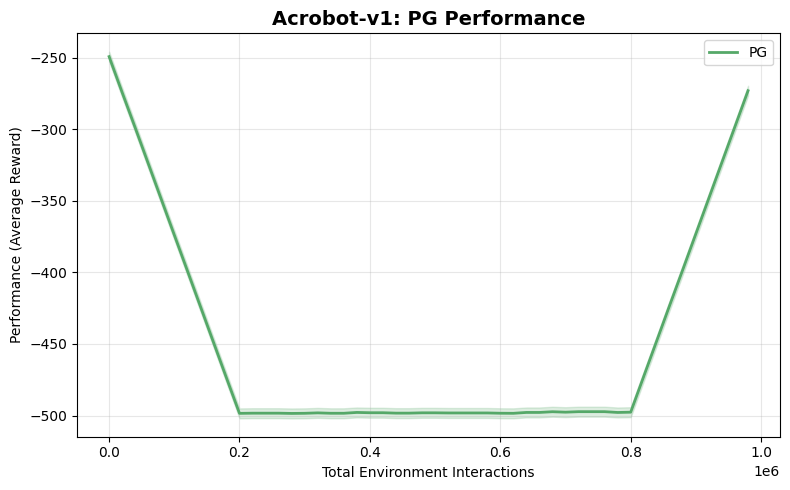

In [7]:
print(PG.num_actions)
print(PG.env)

actor = Actor(PG.num_states, PG.num_actions, PG.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{PG.env}_PG.pth"))

env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{PG.env}_PG.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PG")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{PG.env}: PG Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
PG = PolicyGradient('HalfCheetah-v5')
PG.main()

State space:  17
Action space:  6
10 episode score is -376.82
20 episode score is -357.61
30 episode score is -355.67
40 episode score is -425.36
50 episode score is -374.31
60 episode score is -357.91
70 episode score is -348.02
80 episode score is -384.59
90 episode score is -356.96
100 episode score is -367.72
110 episode score is -358.10
120 episode score is -347.32
130 episode score is -337.69
140 episode score is -359.48
150 episode score is -340.02
160 episode score is -380.39
170 episode score is -346.58
180 episode score is -409.99
190 episode score is -379.92
200 episode score is -321.20
210 episode score is -321.38
220 episode score is -346.30
230 episode score is -397.94
240 episode score is -367.32
250 episode score is -329.78
260 episode score is -351.95
270 episode score is -385.96
280 episode score is -353.70
290 episode score is -351.31
300 episode score is -329.37
310 episode score is -304.79
320 episode score is -331.47
330 episode score is -387.88
340 episode score 

6
HalfCheetah-v5


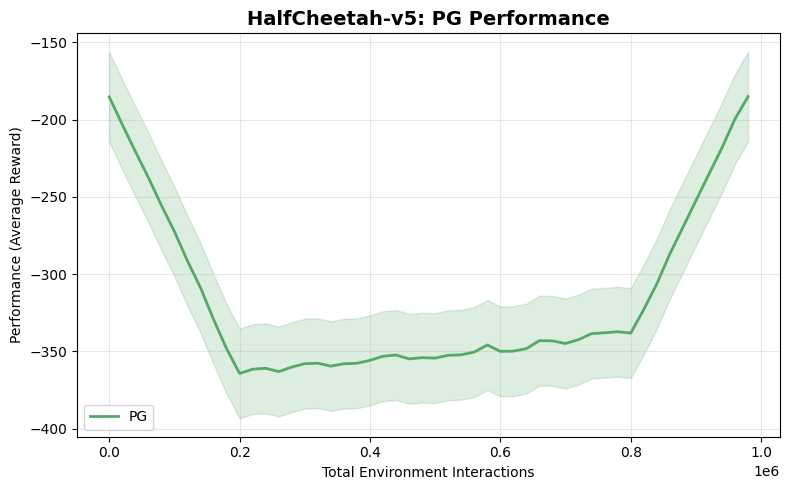

In [9]:
print(PG.num_actions)
print(PG.env)

actor = Actor(PG.num_states, PG.num_actions, PG.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{PG.env}_PG.pth"))

env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{PG.env}_PG.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PG")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{PG.env}: PG Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
PG = PolicyGradient('Reacher-v5')
PG.main()

State space:  10
Action space:  2
200 episode score is -60.65
400 episode score is -60.59
600 episode score is -61.07
800 episode score is -60.67
1000 episode score is -60.22
1200 episode score is -60.58
1400 episode score is -60.35
1600 episode score is -60.33
1800 episode score is -60.88
2000 episode score is -60.86
2200 episode score is -60.52
2400 episode score is -60.70
2600 episode score is -60.81
2800 episode score is -60.44
3000 episode score is -60.95
3200 episode score is -60.95
3400 episode score is -60.26
3600 episode score is -61.00
3800 episode score is -60.43
4000 episode score is -60.88
4200 episode score is -60.80
4400 episode score is -60.94
4600 episode score is -61.12
4800 episode score is -60.71
5000 episode score is -60.57
5200 episode score is -61.27
5400 episode score is -60.71
5600 episode score is -60.40
5800 episode score is -60.65
6000 episode score is -60.61
6200 episode score is -60.54
6400 episode score is -60.99
6600 episode score is -60.62
6800 episode 

2
Reacher-v5


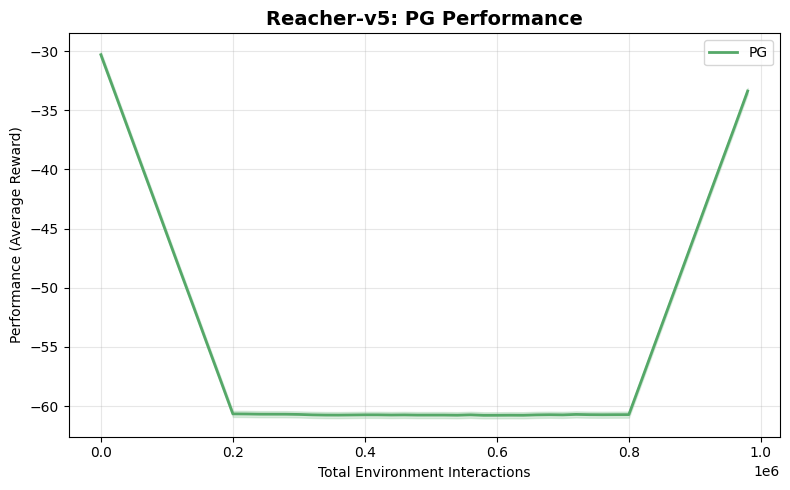

In [11]:
print(PG.num_actions)
print(PG.env)

actor = Actor(PG.num_states, PG.num_actions, PG.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{PG.env}_PG.pth"))

env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{PG.env}_PG.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PG")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{PG.env}: PG Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
PG = PolicyGradient('LunarLander-v3')
PG.main()

State space:  8
Action space:  4


/Users/trijalsrivastava/Code/CS778/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


89 episode score is -185.30
176 episode score is -225.73
262 episode score is -194.52
348 episode score is -214.63
435 episode score is -214.27
521 episode score is -206.39
607 episode score is -188.29
688 episode score is -204.35
766 episode score is -206.83
853 episode score is -186.48
939 episode score is -179.88
1026 episode score is -185.96
1114 episode score is -172.01
1201 episode score is -193.34
1290 episode score is -190.72
1377 episode score is -190.34
1464 episode score is -177.30
1552 episode score is -194.62
1640 episode score is -172.83
1727 episode score is -171.81
1815 episode score is -189.86
1904 episode score is -208.03
1992 episode score is -164.72
2079 episode score is -166.43
2167 episode score is -175.76
2254 episode score is -186.39
2343 episode score is -186.29
2433 episode score is -176.18
2520 episode score is -184.95
2609 episode score is -182.31
2699 episode score is -165.28
2788 episode score is -168.68
2878 episode score is -189.89
2968 episode score is 

4
LunarLander-v3


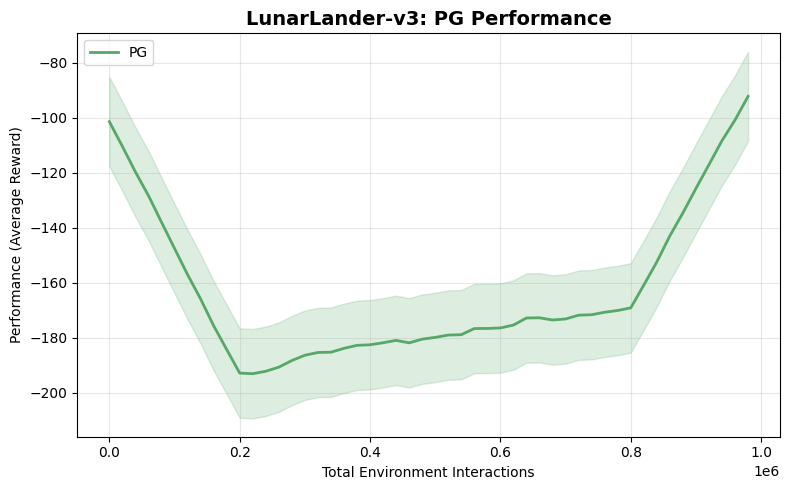

In [13]:
print(PG.num_actions)
print(PG.env)

actor = Actor(PG.num_states, PG.num_actions, PG.isDiscrete)
actor.load_state_dict(torch.load(f"actor_{PG.env}_PG.pth"))

env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0
 
scores = np.load(f"scores_{PG.env}_PG.npy") 

# Optionally, smooth the curve a bit
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smoothed_scores = smooth(scores, box_pts=20)
 
timesteps = np.arange(len(scores)) * 20000   

# Plot
plt.figure(figsize=(8,5))
plt.plot(timesteps, smoothed_scores, color="#55A868", linewidth=2, label="PG")
plt.fill_between(timesteps, smoothed_scores - np.std(scores), 
                 smoothed_scores + np.std(scores), color="#55A868", alpha=0.2)

plt.title(f"{PG.env}: PG Performance", fontsize=14, fontweight='bold')
plt.xlabel("Total Environment Interactions")
plt.ylabel("Performance (Average Reward)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Total episode reward: -95.76339481346544


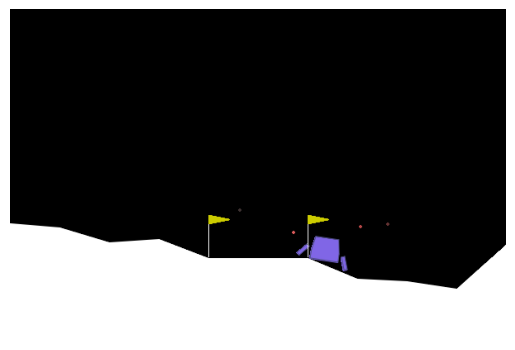

In [14]:


env = PG.env
env = gym.make(env, render_mode="rgb_array")
state, _ = env.reset(seed=42)
done = False
total_reward = 0

frames = []  # for inline animation
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    if actor.isDiscrete:
        logits, _, _ = actor(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().item()
    else:
        mu, std, _ = actor(state_tensor)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample().squeeze(0).detach().numpy()
        action = np.clip(action, env.action_space.low, env.action_space.high)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

    frame = env.render()  # gets RGB array if rgb_array mode
    frames.append(frame)

    state = next_state

for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)


print("Total episode reward:", total_reward)
env.close()


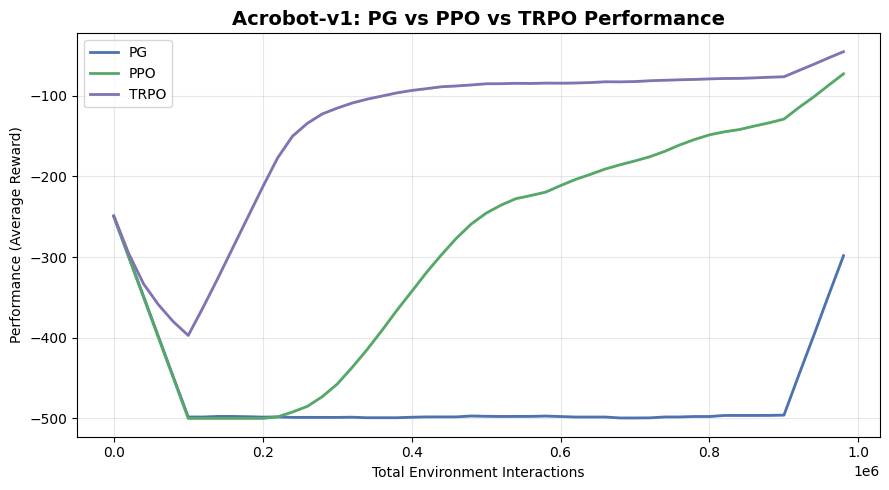

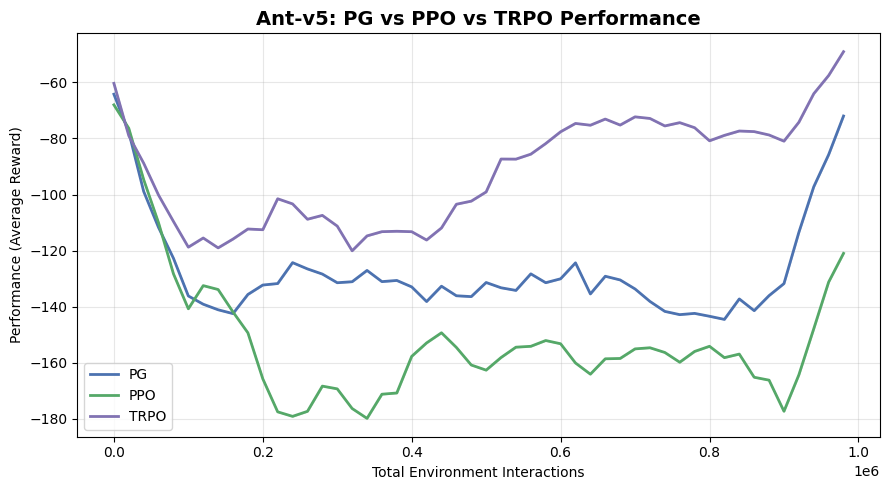

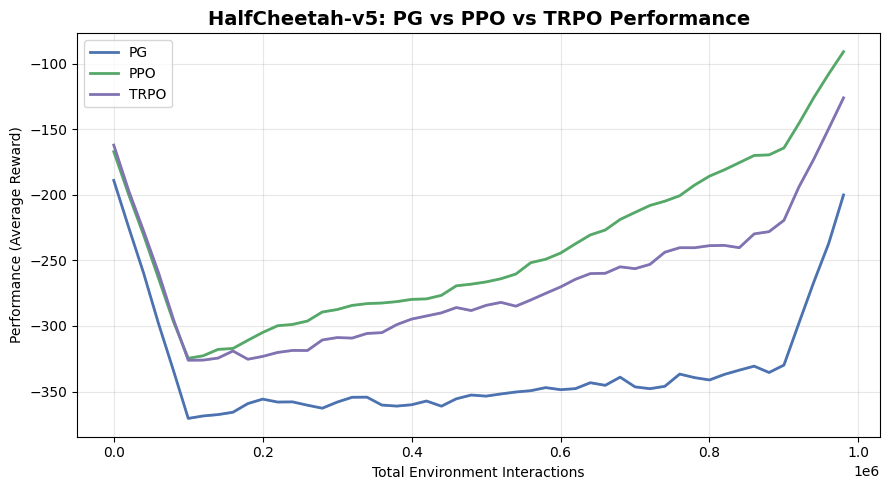

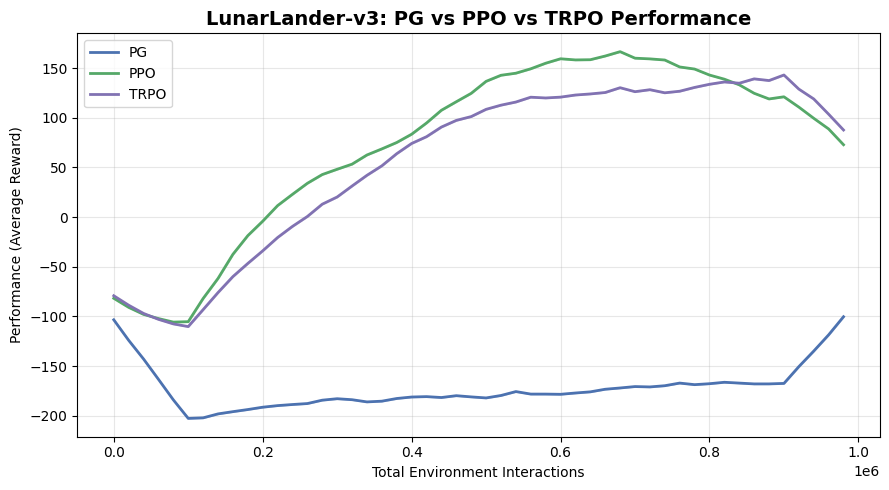

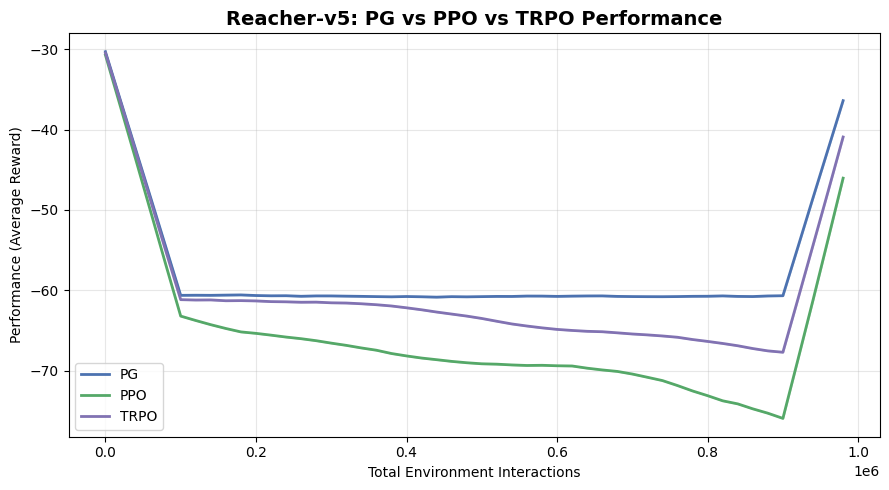

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

plt.style.use('seaborn-v0_8-muted')
 
colors = {
    "PG": "#4C72B0",      
    "PPO": "#55A868",     
    "TRPO": "#8172B2"    
}
 
def smooth(y, box_pts=10):
    if len(y) < box_pts:
        return y
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
 
files = sorted(glob.glob("scores_*.npy")) 
envs = sorted(set(["_".join(f.split("_")[1:-1]) for f in files]))
 
for env in envs:
    plt.figure(figsize=(9, 5)) 

    for algo in ["PG", "PPO", "TRPO"]:
        matching_files = [f for f in files if env in f and algo in f]
        if not matching_files:
            continue

        data = [np.load(f) for f in matching_files if os.path.getsize(f) > 0]
        if not data:
            continue

        rewards = np.array([d for d in data if len(d) > 0])
        if len(rewards.shape) == 1:
            rewards = rewards.reshape(1, -1)

        mean = np.mean(rewards, axis=0)
        std = np.std(rewards, axis=0)

        timesteps = np.arange(len(mean)) * 20000  
        smoothed_mean = smooth(mean, box_pts=10)

        plt.plot(timesteps, smoothed_mean, label=algo, color=colors[algo], linewidth=2)
        plt.fill_between(timesteps, smoothed_mean - std, smoothed_mean + std, color=colors[algo], alpha=0.2)

    plt.title(f"{env}: PG vs PPO vs TRPO Performance", fontsize=14, fontweight='bold')
    plt.xlabel("Total Environment Interactions")
    plt.ylabel("Performance (Average Reward)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{env}_comparison.png", dpi=300)
    plt.show()
 
